In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

## HyperParameters

In [2]:
batch_size = 32 #examples at once
block_size = 64 # max context
max_iters = 5000
eval_interval = 25
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
eval_iters = 200
training_split = 0.9
n_embd = 48
n_heads = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

## Load data to run tokenizer

In [3]:
#training_data = Path('/Users/djemec/data/gpt_train_data/tiny_stories/ts_v2_train.txt')
#validation_data = Path('/Users/djemec/data/gpt_train_data/tiny_stories/ts_v2_valid.txt')
shake_data = Path('/Users/djemec/data/gpt_train_data/tiny_shakespeare/input.txt')

with open(shake_data, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
## build out unique characters for the test
chars = sorted(list(set(text)))
vocab_size = len(chars)

## Tokenizer

First we'll show an example but then base it off of tiktoken which is BPE

In [5]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
# To get the tokeniser corresponding to a specific model in the OpenAI API:
# enc = tiktoken.encoding_for_model('gpt2')

In [6]:
def get_batch(split):
    # generate small batches of data of input X and output Y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def generate_n_ex(m, max_new_tokens):
    # start with 0,0 which is initial character and generate
    context = torch.zeros((1,1), dtype=torch.long, device=device)
    generated_tokens = m.generate(context, max_new_tokens=max_new_tokens)
    # decode token to characters
    print(decode(generated_tokens[0].tolist()))

## Model architecture

In [7]:
class Head(nn.Module):
    ''' one head of self attention '''
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute attention scores
        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B,T,C) @ (B,C,T) --> (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # decoder block to make sure it only knows the past, not future
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out

class MultiHeadAttention(nn.Module):
    ''' multiple heads of self attention in parallel'''

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out =  torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
        

class FeedForward(nn.Module):
    ''' simple linear layer followed by non-linearity'''

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.LeakyReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class Block(nn.Module):
    ''' transformer block: communication followed by computation'''

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [9]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_heads) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx) # B,T,C
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T, C
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) # B, T, vocab_size

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # stretch out the array
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for i in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # becomes (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples = 1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

## load data & split

In [10]:
# create split
data = torch.tensor(encode(text), dtype=torch.long)

n = int(training_split*len(data))
train_data = data[:n] 
val_data = data[n:]

In [11]:
# initiate model
model = BigramLanguageModel()
model = model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.178241 M parameters


In [12]:
# better optimizer over stochastic gradient descent
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### Training with optimmizer

In [13]:
lossi = []

In [21]:
for iter in range(max_iters):
    # periodically evaluate loss
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f'step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}')
        lossi.append(losses['val'])

    #sample data
    xb, yb = get_batch('train')

    # evaluate loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 1.8345, val loss 1.9429
step 25: train loss 1.8319, val loss 1.9409
step 50: train loss 1.8328, val loss 1.9449
step 75: train loss 1.8311, val loss 1.9458
step 100: train loss 1.8287, val loss 1.9389
step 125: train loss 1.8315, val loss 1.9421
step 150: train loss 1.8242, val loss 1.9359
step 175: train loss 1.8369, val loss 1.9473
step 200: train loss 1.8307, val loss 1.9360
step 225: train loss 1.8322, val loss 1.9438
step 250: train loss 1.8316, val loss 1.9341
step 275: train loss 1.8275, val loss 1.9478
step 300: train loss 1.8280, val loss 1.9383
step 325: train loss 1.8254, val loss 1.9373
step 350: train loss 1.8276, val loss 1.9384
step 375: train loss 1.8238, val loss 1.9438
step 400: train loss 1.8295, val loss 1.9426
step 425: train loss 1.8290, val loss 1.9350
step 450: train loss 1.8279, val loss 1.9352
step 475: train loss 1.8220, val loss 1.9385
step 500: train loss 1.8249, val loss 1.9386
step 525: train loss 1.8225, val loss 1.9330
step 550: train

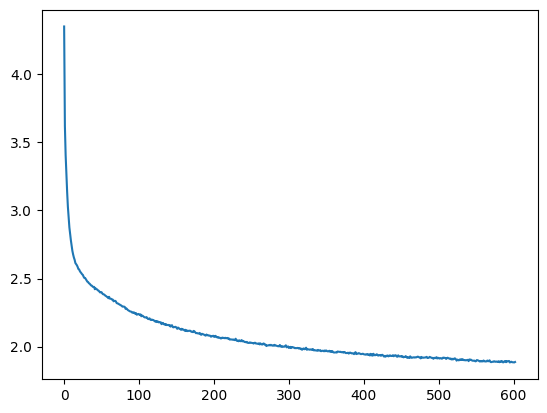

In [22]:
plt.plot(lossi)

In [23]:
generate_n_ex(model, 5000)



MENENIUS:
Seas me els, jurye the in iterly behisers
Make an.
A:
What see to, it, this bagment in the I hight
His him huse telseines.
Where keving sheen whem'douly thee he my cotal?
' maf stirkngs-we me pesth;
For year weret it the sono, when; for Thoure u!
I groom that fedvoy name that pote tony cowgr!
My wowif! I love apy Clicive steer and love
thougge-o a con then'd I gupherveer turbrieed
us would I till teair pacey! wyour misoncie.
Why sa hengels, our goe houscts befow: thot,
And ithy husself.

ARIANNGLIES:
As yor fam nother: yepenss, that I
Indot touth fath toour bloodks caust gon,
If thou rotle plunifes:
whou by the pisbjery arre, bruth to caurbly! you.

GLOUCES ELOUSRGANC:
Swernch mely!

GLANES:
His hasentain ourad hear?
Came, that feace my seorth ep, thee man houd stay
tered thy knows were me, hat more fier mefol,
Sitsm for Yedlum.
Then mauty calsanom.
Those not: Whith I lefet lieke
Hingentiong storters.

ROMERCH:
Noth soumeny cere kims mpardy be your thy loave,
I sell dut spa